# Analysis of HPL

This notebook performs data analysis of the csv files created by running the HPL benchmark

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

# Standardise Fonts
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8) 
plt.rc('axes', titlesize=10)
plt.rc("axes", labelsize=8)

In [2]:
# Store the results in a dictionary of lists
results = {
    "Cloud_HPL":[],
    "SCARF_HPL":[],
    "JASMIN_HPL":[]
}

# Parse data from csvs from each of the different results
for dataName in results:
    with open("../" + dataName + "/out.csv", "r") as fHandle:
        reader = csv.reader(fHandle)  # create an iterator over each row
        headers = next(reader) # the headers are the first line
        for row in reader:
            thisRow = dict((header, row[index]) for index, header in enumerate(headers))
            results[dataName].append(thisRow)
            

# Print a taste of the data, for a quick check that it worked
for dataName in results:
    print(dataName)
    print("1st datapoints")
    print(results[dataName][0])
    print("Headers")
    print(results[dataName][0].keys())
    print()
        

SCARF_HPL
1st datapoints
{'Time': '447.67', 'N': '44640', 'Start Time': 'Thu Mar 23 11:31:26 2017', 'Exclusive': '1', 'Total Requested Memory (MB)': '-', 'Max Processes': '12', 'P': '2', 'Run time (sec.)': '489', 'Number of Hosts': '1', 'Hosts Used': '4*cn528.scarf.rl.ac.uk', 'NB': '180', 'T/V': 'WR11R2C4', 'Average Memory (MB)': '13533.07', 'Protocols Seen': 'SHM', 'Host Groups': 'scarf15', 'Max Threads': '14', 'Turnaround time (sec.)': '481', 'CPU time (sec.)': '1898.16', 'Max Memory (MB)': '15576.47', 'Gflops': '1.325e+02', 'File Name': '482673.out', 'Max Swap (MB)': '16549', 'Delta Memory (MB)': '-', 'Q': '2'}
Headers
dict_keys(['Time', 'N', 'Start Time', 'Exclusive', 'Total Requested Memory (MB)', 'Max Processes', 'P', 'Run time (sec.)', 'Number of Hosts', 'Hosts Used', 'NB', 'T/V', 'Average Memory (MB)', 'Protocols Seen', 'Host Groups', 'Max Threads', 'Turnaround time (sec.)', 'CPU time (sec.)', 'Max Memory (MB)', 'Gflops', 'File Name', 'Max Swap (MB)', 'Delta Memory (MB)', 'Q'])

In [3]:
import datetime

# Do cloud dates:
for result in results["Cloud_HPL"]:
    result["Date Run"] = datetime.datetime.strptime(result["File Name"], "%Y%m%d_%H%M%S.out")

# Make SCARF and JASMIN uppercase and map 'X-X' -> 'X'
for name in ("SCARF_HPL", "JASMIN_HPL"):
    for result in results[name]:
        result["Host Groups"] = result["Host Groups"].split("-")[0].upper()
    

    

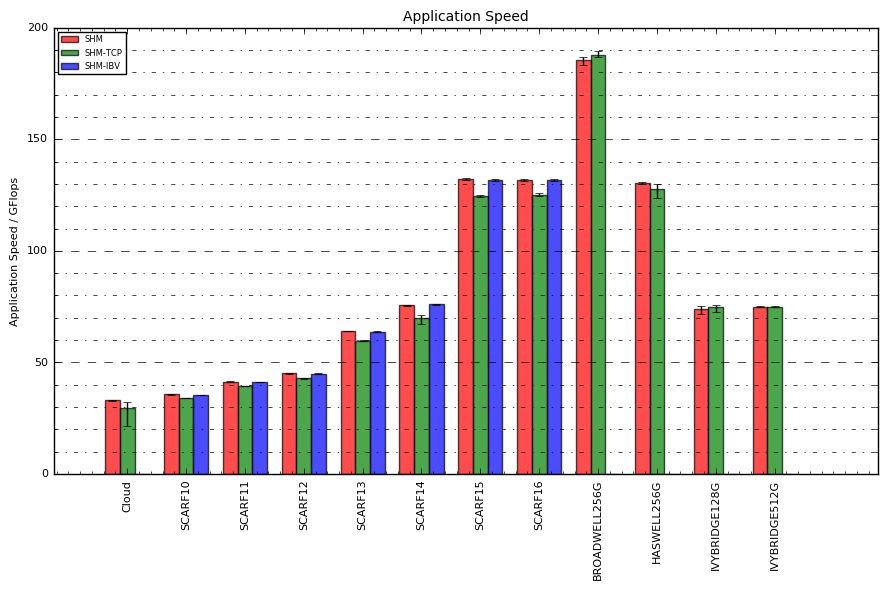

In [4]:
def plotGflops(BW_KEY="Gflops"):
    
    xValues = []
    clrs = {"SHM": "r", "SHM-TCP":"g", "SHM-IBV":"b"}
    yValues = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yTopError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    yBottomError = {"SHM":[], "SHM-TCP":[], "SHM-IBV":[]}
    
    def addBarData(listOfData, label):
        listOfData = [float(val) for val in listOfData]
        nonlocal yValues
        nonlocal yTopError
        nonlocal yBottomError
        avg = sum(listOfData) / len(listOfData)
        yValues[label].append(avg)
        yTopError[label].append(max(listOfData) - avg)
        yBottomError[label].append(avg - min(listOfData))
    
    
    # Add the cloud split into number of hosts
    addBarData([row[BW_KEY] for row in results["Cloud_HPL"] if row["Number of Hosts"] == "1"], "SHM")
    addBarData([row[BW_KEY] for row in results["Cloud_HPL"] if row["Number of Hosts"] == "2"], "SHM-TCP")
    addBarData([0], "SHM-IBV")

    xValues.append("Cloud")
    
   
    # Add the JASMIN and SCARF data split into host group and number of hosts
    for name in ("SCARF_HPL", "JASMIN_HPL"):
        for hostgroup in sorted(set(row["Host Groups"] for row in results[name])):
            xValues += [hostgroup]
            for prot in clrs.keys():
                
                thisData = [row[BW_KEY] for row in results[name] 
                            if hostgroup in row["Host Groups"] and prot == row["Protocols Seen"]]
                if len(thisData) == 0:  # if no data then there is a divide by zero so send this (mostly IBV)
                    addBarData([0], prot)
                else:
                    addBarData(thisData, prot)
    
    index = np.arange(len(xValues)) - 1
    
    bar_width=0.25
    plt.rcParams["figure.figsize"] = (9,6)
    ax = plt.gca()
    plt.minorticks_on()
    ax.yaxis.grid(True, which='major', linestyle='--')
    ax.yaxis.grid(True, which='minor', linestyle='-.')
    
    for i, (label, yVals) in enumerate(yValues.items()):
        plt.bar(index + i * bar_width, yVals, bar_width, align='center', color=clrs[label], alpha=0.7, label=label)
        plt.errorbar(index + i * bar_width, yVals, yerr=[yBottomError[label], yTopError[label]], linestyle=" ", 
                     color="black", zorder=6)
    
    plt.xticks(index + bar_width, xValues, rotation="vertical")
    plt.ylabel("Application Speed / GFlops")
    # plt.yscale("log")
    plt.title('Application Speed')
    
    plt.legend(loc=2, fontsize=6)
    plt.tight_layout()
    
    plt.show()
    


plotGflops()